In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import xesmf
import cf_xarray as cfxr
import pandas as pd
import seaborn as sns

In [4]:
from weatherbench2.metrics import MAE, _spatial_average

Read in ERA

In [5]:
from p1stacked import P1Emulator

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [6]:
p1 = P1Emulator()

In [7]:
from graphufs.datasets import Dataset

In [8]:
fig_dir = "figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [9]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [10]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [11]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [109]:
truths = ["ERA5", "HRES Analysis"]
models = [
    "GraphUFS",
    "GraphCast",
    "Pangu",
    "ERA5 Forecasts",
    "IFS ENS Mean",
    "Replay", # bit of a misnomer
]

In [150]:
duration = "240h"
year = 2018

location = "/p1-evaluation/v1/validation"

errors = {}
spectra = {}
spatial = {}

for model in models:
    name = model.lower().replace(" ", "_")
    errors[model] = {}
    spatial[model] = {}
    if model in ("GraphUFS", "Replay"):
        spectra[model] = open_zarr(f"{location}/{name}.{duration}.spectra.zarr")
    else:
        spectra[model] = open_zarr(f"{location}/{name}.{year}.spectra.zarr")
        
    for truth in truths:
        tname = truth.lower().replace(" ", "_")
        if model in ("GraphUFS", "Replay"):
            errors[model][truth] = open_dataset(f"{location}/{name}_vs_{tname}_{duration}_deterministic.nc")
            spatial[model][truth] = open_dataset(f"{location}/{name}_vs_{tname}_{duration}_deterministic_spatial.nc")
        else:
            errors[model][truth] = open_dataset(f"{location}/{name}_vs_{tname}_{year}_deterministic.nc")
            spatial[model][truth] = open_dataset(f"{location}/{name}_vs_{tname}_{year}_deterministic_spatial.nc")

In [111]:
def calc_mae(forecast, obs):
    xds = xr.Dataset()
    xds["time"] = forecast.time.copy()
    xds["fhr"] = forecast.fhr.copy()

    for key in forecast.data_vars:

        dalist = []
        for time in forecast.time.values:
            if time in obs.time and key in obs:
                oda = obs[key]
                oda["lead_time"] = obs.time - obs.time.sel(time=time)
                oda = oda.swap_dims({"time": "lead_time"})
                oda = oda.drop_vars("time")
                fcst = forecast[key].sel(time=time).swap_dims({"fhr":"lead_time"})
                mae = np.abs(oda - fcst)
                mae = _spatial_average(mae)
                mae = mae.expand_dims({"metric": ["mae"], "time": [time]})
                mae = mae.swap_dims({"lead_time": "fhr"})
                dalist.append(mae)
        if len(dalist) > 0:
            xds[key] = xr.DataArray(
                xr.concat(dalist, dim="time"),
                dims=("metric", "time", "fhr") if "level" not in forecast[key].dims else ("metric", "time", "fhr", "level"),
            ).mean("time")

    return xds

In [112]:
def calc_wb2_mae(forecast, obs):

    mae = MAE()
    err = mae.compute(
        forecast=forecast,
        truth=obs,
    )
    err = err.expand_dims({"metric": ["mae"]})

    return err


In [113]:
def plot_surface_metrics(
    mds,
    truth,
    metric="mae",
    fields=("2m_temperature", "surface_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind"),
):

    ncols = len(fields)
    fig, axs = plt.subplots(1, ncols, figsize=(ncols*3, 4), constrained_layout=True)

    for i, (fld, ax) in enumerate(zip(fields, axs)):
        
        for j, (label, xdict) in enumerate(mds.items()):
            xds = xdict[truth]
            kw = {
                "ax": ax,
                "color": f"C{j}" if label != "Replay" else "gray",
            }
            skw = {
                "linewidth": 2,
                **kw,
            }
            mkw = {
                "alpha": .2,
                "x": "fhr",
                "add_legend": False,
                **kw,
            }
            if xds is not None:
                if fld in xds:
                    xds[fld].sel(metric=metric).plot(label=label if i == 0 else None, **skw)
    
        fname = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
        title = fname
        xticks = mds["GraphUFS"][truth].fhr.values[3::4]
        ylim = [0, None] if metric == "mae" else [None, None]
        ax.set(
            xlabel="Lead time (days)",
            ylabel="",
            title=title,
            xticks=xticks,
            xticklabels=[x//24 for x in xticks],
            ylim=ylim,
            xlim=[None, 245],
        )
        for key in ["right", "top"]:
            ax.spines[key].set_visible(False)
    
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))
    fig.suptitle(f"{metric.upper()} vs {truth}")
    return fig, axs

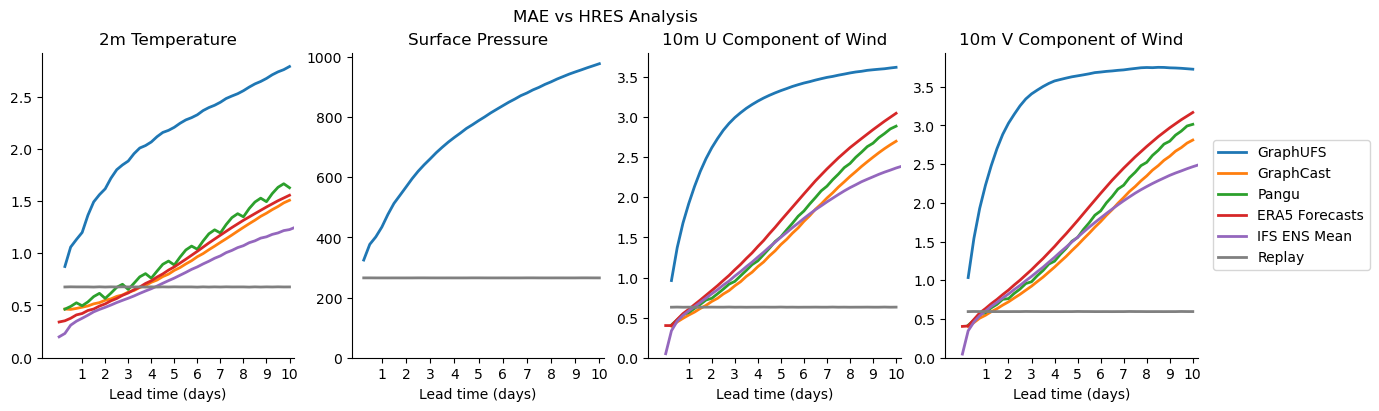

In [114]:
#fig, axs = plot_surface_metrics(errors, truth="ERA5")
fig, axs = plot_surface_metrics(errors, truth="HRES Analysis")
#fig.savefig(f"{fig_dir}/mae_vs_era5_surface.pdf", bbox_inches="tight")
#fig.savefig(f"{fig_dir}/mae_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

## Relative Error

Originally I was thinking
$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{trainer}_1, \text{trainer}_2)}$$

e.g. 

$$ \dfrac{|\text{GraphUFS} - \text{Replay}|}{|\text{Replay} - \text{ERA5}|}$$

But now it's like this (just for ease of what we have available)

$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{Replay}, \text{HRES Analysis})}$$

Which no matter what gives us some kind of independent estimate of "how close we should be" for the denominator, even when we use it on a dataset trained on ERA5.

So this is

$$ \dfrac{|\text{GraphUFS} - \text{Replay}|}{|\text{Replay} - \text{HRES Analysis}|}$$
$$ \dfrac{|\text{GraphCast} - \text{ERA5}|}{|\text{Replay} - \text{HRES Analysis}|}$$
$$ \dfrac{|\text{Pangu} - \text{ERA5}|}{|\text{Replay} - \text{HRES Analysis}|}$$

In [141]:
gufs = open_zarr("/p1-evaluation/v1/validation/graphufs.240h.postprocessed.zarr/")
replay = open_zarr("/p1-evaluation/v1/validation/replay.240h.postprocessed.zarr/")

In [142]:
mae_replay = calc_wb2_mae(gufs, replay)

In [143]:
relative_errors = {
    "GraphUFS": {
        "HRES Analysis": mae_replay / errors["Replay"]["HRES Analysis"],
    },
}

In [148]:
for key in ["GraphCast", "Pangu"]:
    relative_errors[key] = {"HRES Analysis": errors[key]["ERA5"] / errors["Replay"]["HRES Analysis"]}

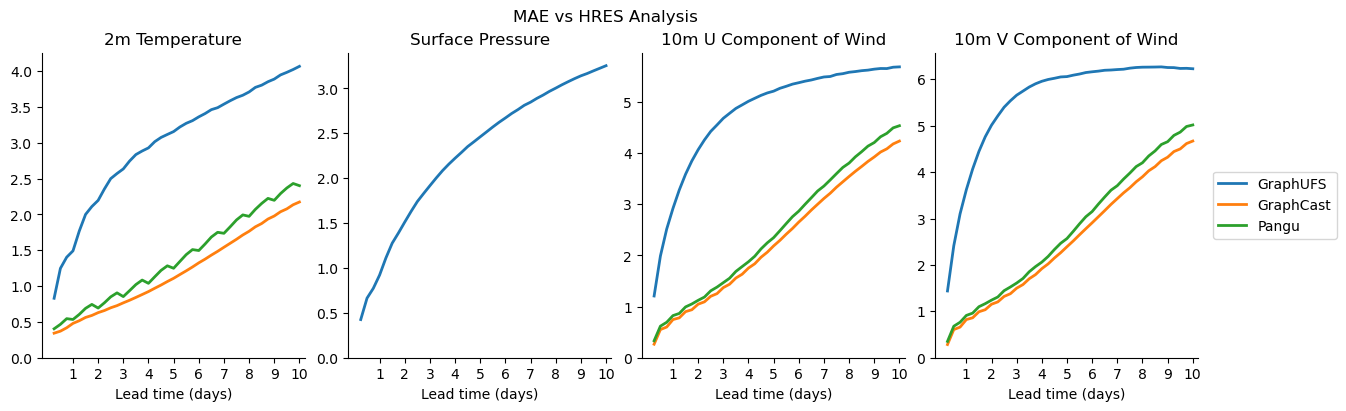

In [149]:
fig, axs = plot_surface_metrics(
    mds=relative_errors,
    truth="HRES Analysis",
)
#fig.savefig(f"{fig_dir}/relative_mae_surface.jpeg", bbox_inches="tight", dpi=300)

## Spectra

In [120]:
def plot_spectra(
    mds,
    fhr,
    fields=("2m_temperature", "surface_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind"),
    use_seaborn=False,
    show_diff=False,
):
    ncols = len(fields)
    fig, axs = plt.subplots(1, ncols, figsize=(ncols*3, 4), constrained_layout=True)

    for i, (fld, ax) in enumerate(zip(fields, axs)):
        
        for j, (label, xds) in enumerate(mds.items()):
            kw = {
                "ax": ax,
                "x": "zonal_wavenumber",
                "color": f"C{j}" if label != "Replay" else "gray",
                "label": label if i == 0 else None,
                "linewidth": 2,
            }
            if (show_diff and label != "Replay") or not show_diff:
                if fld in xds:
                    plotme = xds[fld].sel(fhr=fhr)
                    if show_diff:
                        plotme = plotme - mds["Replay"][fld].sel(fhr=fhr)
                        plotme = np.abs(plotme)
                        plotme /= np.abs(mds["Replay"][fld].sel(fhr=fhr))
                    if use_seaborn:
                        sns.lineplot(
                            data=plotme.to_dataframe().reset_index(),
                            y=fld,
                            legend=False,
                            **kw,
                        )
                    else:
                        plotme.mean("latitude").plot(add_legend=False, **kw)
        fname = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
        title = fname
        ax.set(
            xlabel="Zonal Wavenumber",
            ylabel="",
            title=title,
            xscale="log",
            yscale="log",
            ylim=[6e3, 1e6] if fld != "surface_pressure" and not show_diff else [None, None],
            xlim=[5e1, None],
        )
        for key in ["right", "top"]:
            ax.spines[key].set_visible(False)
    
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))
    return fig, axs

In [121]:
show_diff = False

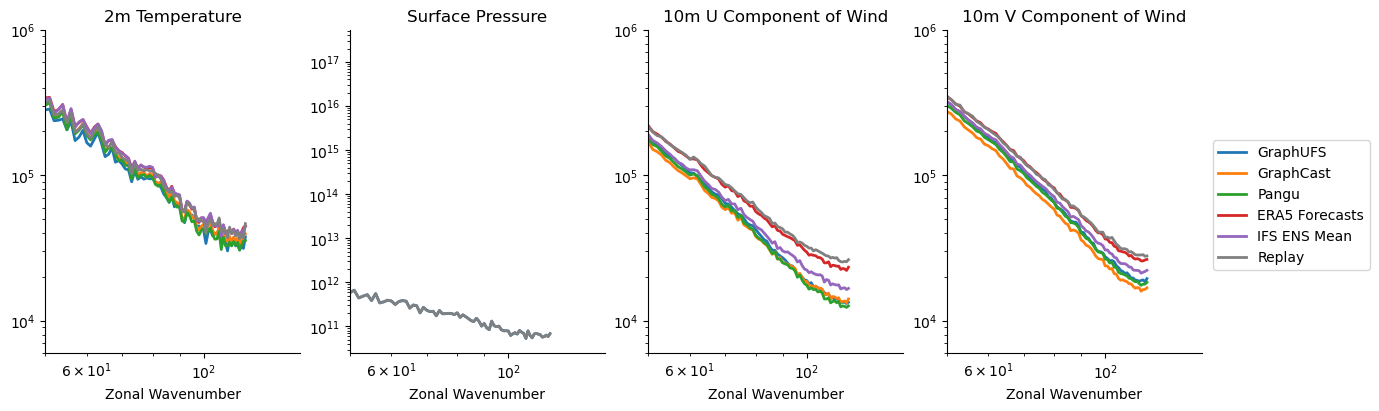

In [138]:
fig, axs = plot_spectra(spectra, fhr=12, use_seaborn=False, show_diff=show_diff)

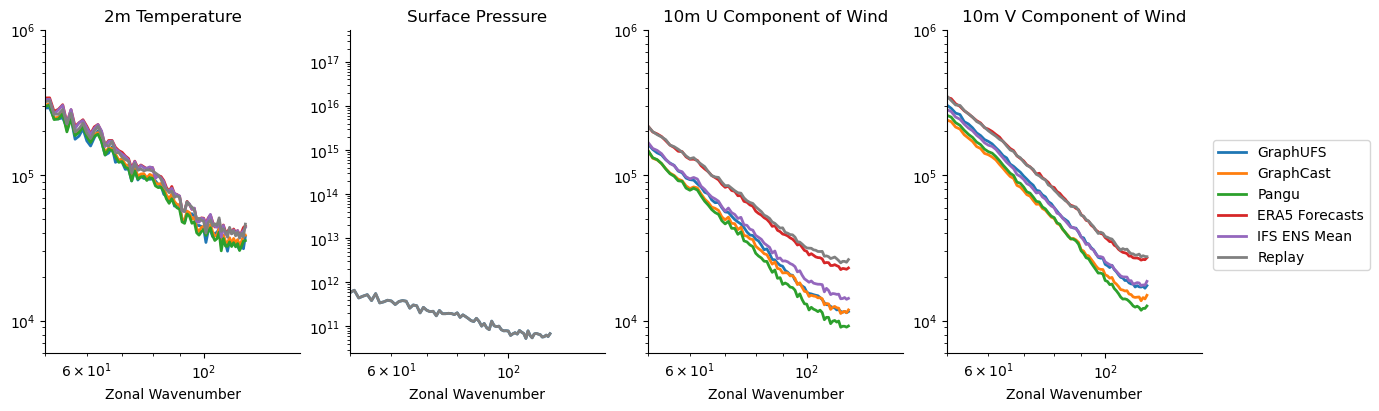

In [139]:
fig, axs = plot_spectra(spectra, fhr=24, use_seaborn=False, show_diff=show_diff)

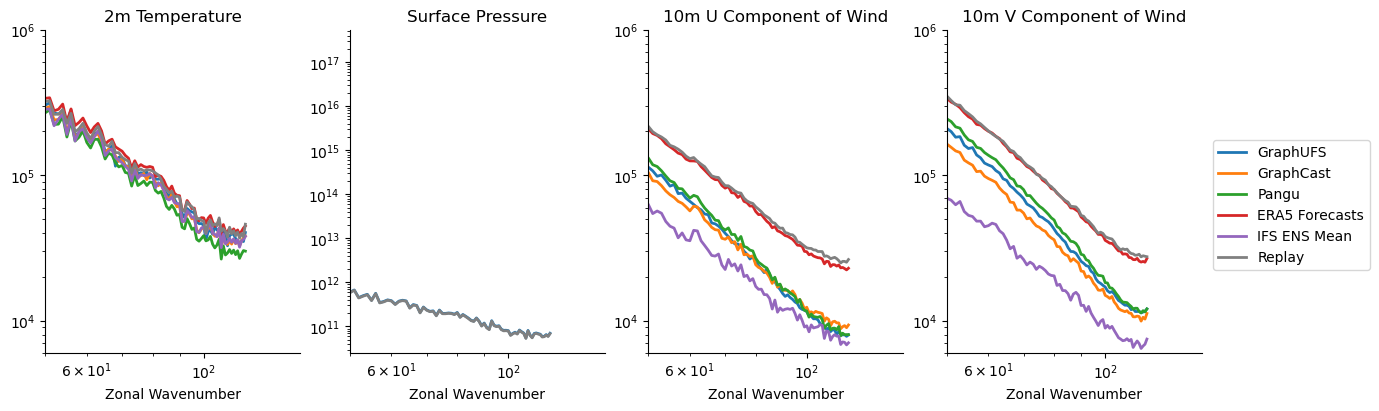

In [140]:
fig, axs = plot_spectra(spectra, fhr=240, use_seaborn=False, show_diff=show_diff)

## Spatial Plots

In [195]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [218]:
def plot_spatial_metrics(
    mds,
    truth,
    fhr,
    metric="mae",
    fields=("2m_temperature", "surface_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind"),
):

    nrows = len(mds)
    ncols = len(fields)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, 4*nrows), constrained_layout=True, sharex=True, sharey=True)

    for i, (fld, axc) in enumerate(zip(fields, axs.T)):

        vmax = np.nanmax([xds[truth][fld].sel(metric=metric, fhr=fhr).max().values if fld in xds[truth] else np.nan for xds in mds.values()])
        vmin = np.nanmin([xds[truth][fld].sel(metric=metric, fhr=fhr).min().values if fld in xds[truth] else np.nan for xds in mds.values()])

        
        cmap = "viridis"
        if vmax*vmin < 0:
            cmap = "RdBu_r"
            vmax = np.max([vmax, -vmin])
            vmin = -vmax
        else:
            vmin = 0.
        
        for j, (label, xdict) in enumerate(mds.items()):
            ax = axc[j]
            xds = xdict[truth]
            kw = {
                "ax": ax,
                "x": "longitude",
                "vmin": vmin,
                "vmax": vmax,
                "add_colorbar": False,
                "cmap": cmap,
            }
            if fld in xds:
                plotme = xds[fld].sel(metric=metric, fhr=fhr)
                p = plotme.plot(label=label if i == 0 else None, **kw)
    
                fname = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
            else:
                fname = ""
            title = fname
            sps = ax.get_subplotspec()
            ax.set(
                xlabel="",
                ylabel=label,
                title=title,
            ) 
            if not sps.is_first_col():
                ax.set(
                    ylabel="",
                    yticks=[],
                )
            if not sps.is_last_col():
                ax.set(xticks=[])

            if not sps.is_first_row():
                ax.set(title="")
            
            for key in ax.spines.keys():
                ax.spines[key].set_visible(False)

            if sps.is_last_row():
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("bottom", size="5%", pad=0.1)
                ticks = np.linspace(vmin, vmax, 3)
                fig.colorbar(p, cax=cax, ticks=ticks, orientation="horizontal")
            #    fig.colorbar(p, cax=axc, orientation="horizontal")

    
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))
    fig.suptitle(f"{metric.upper()} vs {truth}")
    return fig, axs

/tmp/ipykernel_5548/3723836310.py:74: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  fig.legend(loc="center left", bbox_to_anchor=(1, .5))


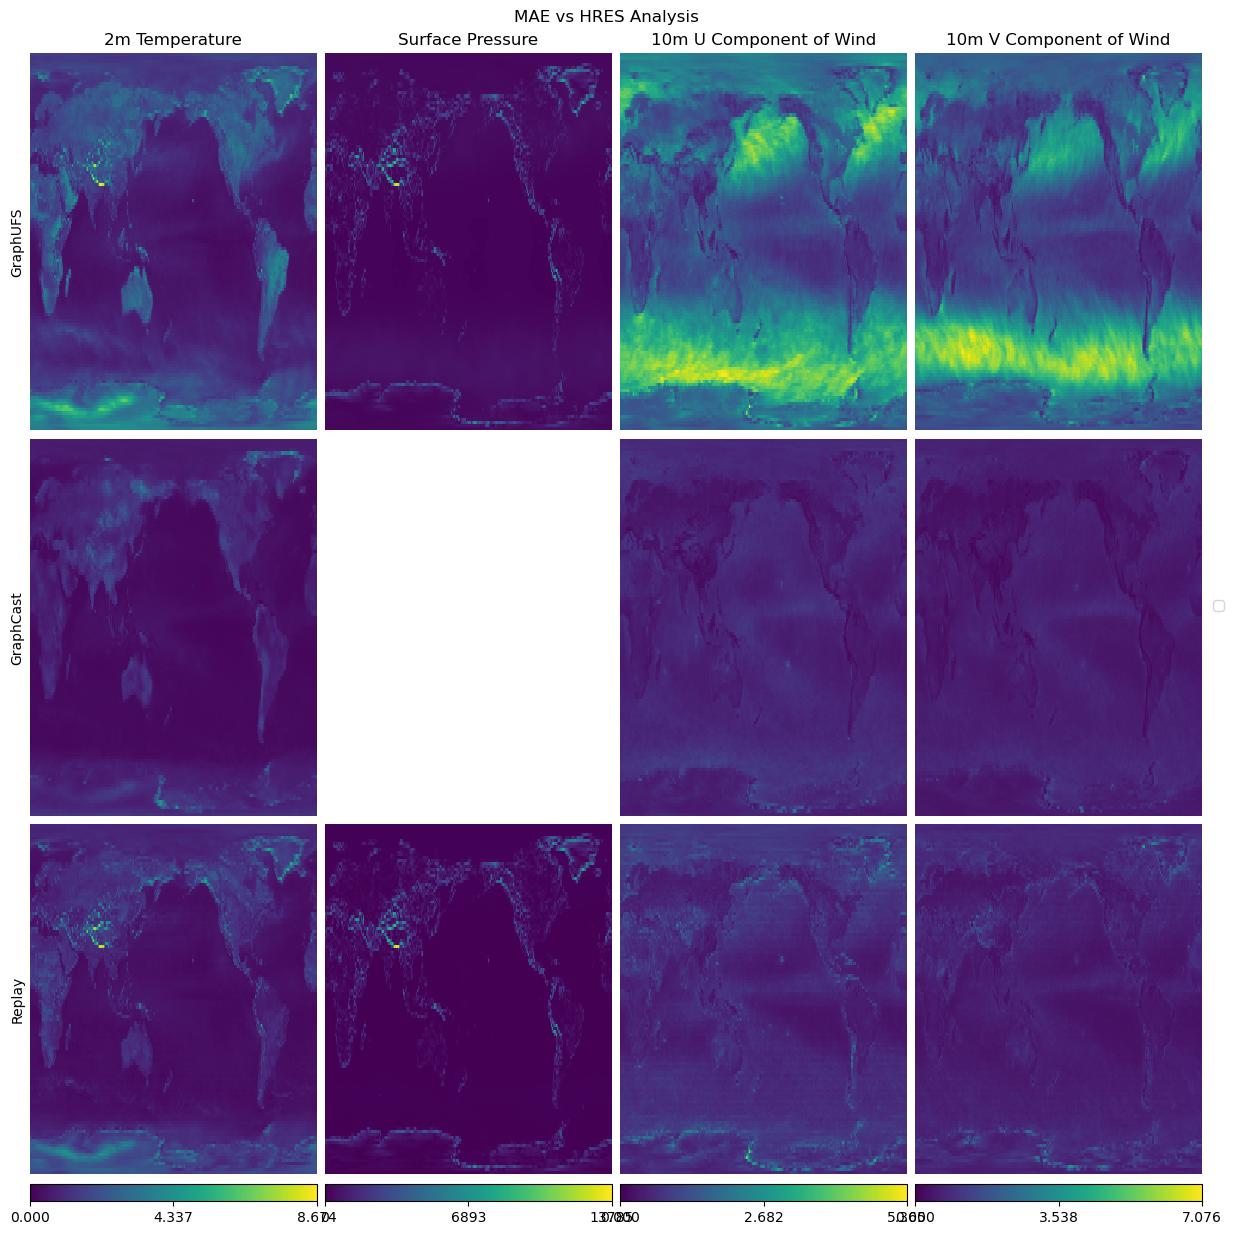

In [219]:
fig, axs = plot_spatial_metrics(
    {k: v for k, v in spatial.items() if k in ["GraphUFS", "GraphCast", "Replay"]},
    truth="HRES Analysis",
    fhr=24,
    metric="mae",
)

## Scratch spatial

In [225]:
era = xr.open_zarr(p1.wb2_obs_url, storage_options={"token": "anon"})
era = era.sel(time=slice(p1.validation_dates[0], p1.validation_dates[1]))
era = era.sel(level=[100, 500, 850])
era = era.sel(latitude=slice(-89,89))

In [228]:
date

Timestamp('2022-02-01 12:00:00')

In [229]:
gufs.time.values

array(['2022-01-04T12:00:00.000000000', '2022-01-06T18:00:00.000000000',
       '2022-01-09T00:00:00.000000000', '2022-01-11T06:00:00.000000000',
       '2022-01-13T12:00:00.000000000', '2022-01-15T18:00:00.000000000',
       '2022-01-18T00:00:00.000000000', '2022-01-20T06:00:00.000000000',
       '2022-01-22T12:00:00.000000000', '2022-01-24T18:00:00.000000000',
       '2022-01-27T00:00:00.000000000', '2022-01-29T06:00:00.000000000',
       '2022-01-31T12:00:00.000000000', '2022-02-02T18:00:00.000000000',
       '2022-02-05T00:00:00.000000000', '2022-02-07T06:00:00.000000000',
       '2022-02-09T12:00:00.000000000', '2022-02-11T18:00:00.000000000',
       '2022-02-14T00:00:00.000000000', '2022-02-16T06:00:00.000000000',
       '2022-02-18T12:00:00.000000000', '2022-02-20T18:00:00.000000000',
       '2022-02-23T00:00:00.000000000', '2022-02-25T06:00:00.000000000',
       '2022-02-27T12:00:00.000000000', '2022-03-01T18:00:00.000000000',
       '2022-03-04T00:00:00.000000000', '2022-03-06

In [230]:
gufs.time[itime].values

numpy.datetime64('2022-01-22T12:00:00.000000000')

In [231]:
era.time.values

array(['2022-01-01T00:00:00.000000000', '2022-01-01T06:00:00.000000000',
       '2022-01-01T12:00:00.000000000', ...,
       '2023-01-10T06:00:00.000000000', '2023-01-10T12:00:00.000000000',
       '2023-01-10T18:00:00.000000000'], dtype='datetime64[ns]')

Plotting ...
  t0 = 2022-01-22T12:00:00.000000000
  lead = 24 hours
  date = 2022-01-23 12:00:00 hours


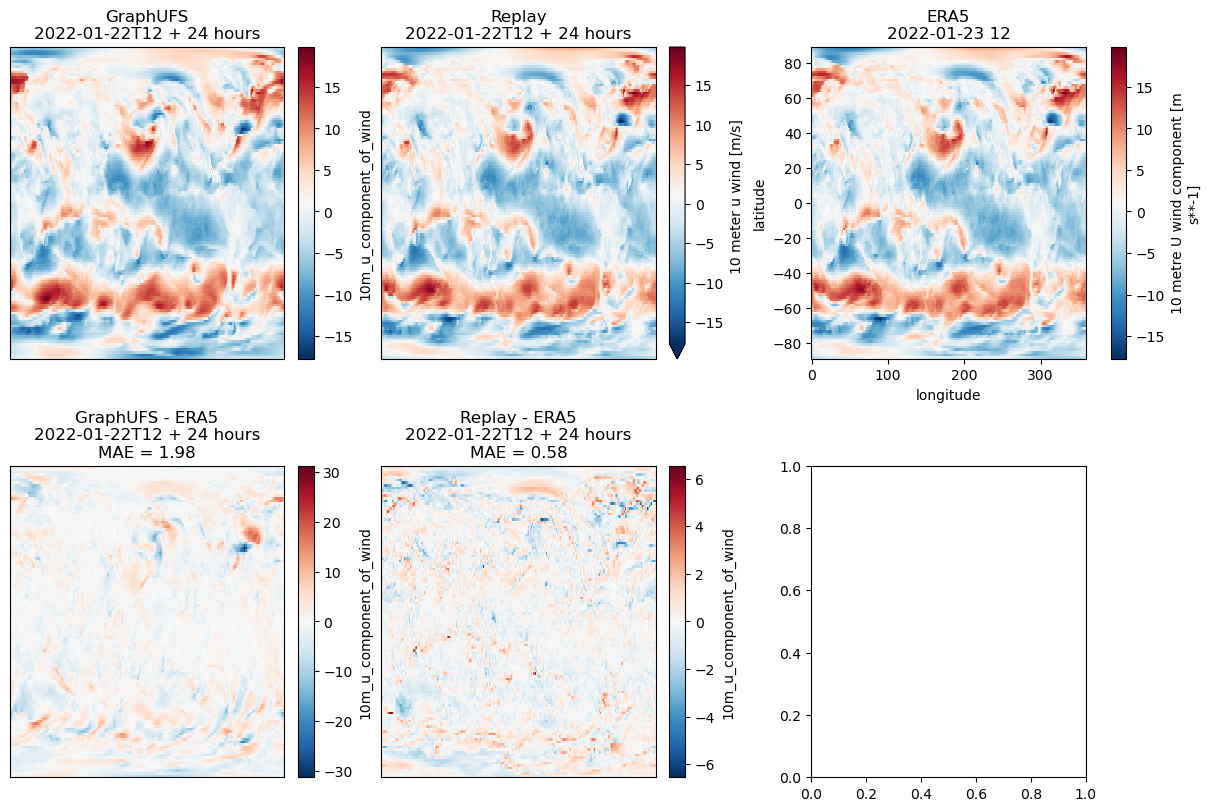

In [234]:
fld = "10m_u_component_of_wind"
clearaxes = {"xticks": [], "yticks": [], "xlabel":"", "ylabel":""}

itime = 8
fhr = 24

t0 = gufs.time[itime].values
date = pd.Timestamp(t0) + pd.Timedelta(f"{fhr}h")

print("Plotting ...")
print(f"  t0 = {str(t0)}")

print(f"  lead = {fhr} hours")
print(f"  date = {date} hours")


fig, axs = plt.subplots(2,3, figsize=(12, 8), constrained_layout=True)

baseline = era[fld].sel(time=date)
vmin = baseline.min().values
vmax = baseline.max().values
cmap = "RdBu_r" if vmin * vmax < 0 else "viridis"


for i, (xds, label) in enumerate(zip(
    [gufs, replay],
    ["GraphUFS", "Replay"],
)):

    ax = axs[0, i]
    plotme =xds[fld].isel(time=itime).sel(fhr=fhr)
    plotme.plot(ax=ax, x="longitude", vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set(
        title=f"{label}\n{str(t0)[:13]} + {fhr} hours",
        **clearaxes,
    )
    ax=axs[1,i]
    diff = plotme-baseline
    mae = np.abs(diff).mean().values
    diff.plot(ax=ax, x="longitude",)
    ax.set(
        title=f"{label} - ERA5\n{str(t0)[:13]} + {fhr} hours\nMAE = {mae:1.2f}",
        **clearaxes,
    )
    
baseline.plot(ax=axs[0, -1], x="longitude", cmap=cmap, vmin=vmin, vmax=vmax)
axs[0,-1].set(title=f"ERA5\n{str(date)[:13]}")
axs[1,-1].clear()